# Imports

In [ ]:
!pip install lime

In [ ]:
!pip install numpy==1.25.0 --no-cache-dir --force-reinstall
!pip install jaxlib --no-cache-dir --force-reinstall
!pip install jax --no-cache-dir --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 145.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.


ERROR: Operation cancelled by user
Traceback (most recent call last):
^C
^C


In [ ]:
!pip install lime shap

In [ ]:
!pip install alibi

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from matplotlib import ticker as mtick
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from alibi.explainers import ALE

# Neural Network Model

In [ ]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [ ]:
def evaluate_model1(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Neural Network Evaluation
Accuracy: 0.89
Precision: 0.85
Recall: 0.98
F1 Score: 0.91
AUC: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.87       544
           1       0.85      0.98      0.91       635

    accuracy                           0.89      1179
   macro avg       0.91      0.89      0.89      1179
weighted avg       0.90      0.89      0.89      1179



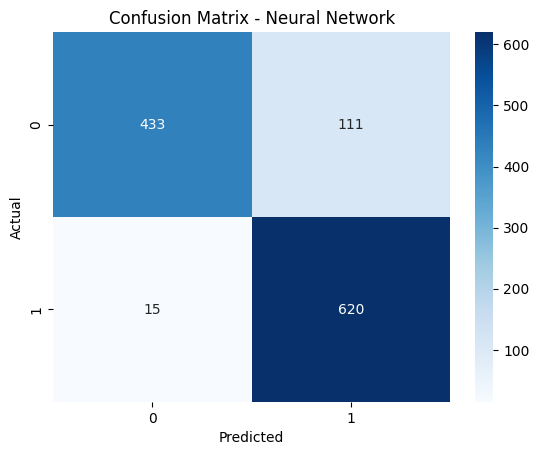

In [ ]:
nn_final = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
nn_final.fit(X_train_final, y_train)
evaluate_model1("Neural Network", nn_final, X_test_final, y_test)

### LIME for NN

In [ ]:
print("\nLIME Explanation for Neural Network (MLP)")
exp = explainer.explain_instance(sample_instance.values, nn_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for Neural Network (MLP)


Predicted churn probability = 93%.

The model strongly believes the customer will churn.

Key contributors toward churn:

* Low TotalCharges (≤ 247.16): strongest indicator of churn (0.45).

* Low discount_score: they’re not receiving a price benefit.

* High MonthlyCostPerTenure: paying more in a shorter time.

Key contributors against churn:
* Features like OnlineSecurity_Yes = 0, OnlineBackup_No = 1, and StreamingMovies_Yes = 0 help reduce churn risk slightly, but not enough to outweigh the stronger churn signals.

This customer is flagged as high risk of churn due to paying high costs early (MonthlyCostPerTenure, TotalCharges), not receiving discounts, and lacking certain support features.

### PDP for NN


PDP - MLP


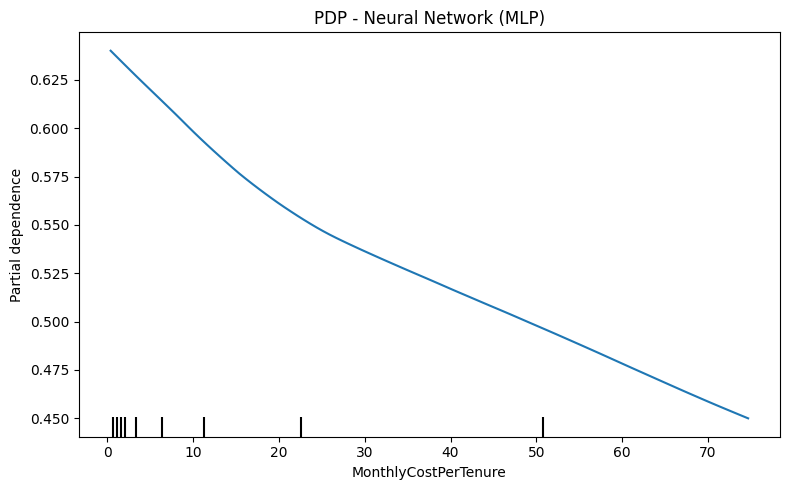

In [ ]:
print("\nPDP - MLP")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(nn_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Neural Network (MLP)")
plt.tight_layout()
plt.show()

This PDP for the Neural Network (MLP) model shows how MonthlyCostPerTenure affects the average predicted churn probability.

Negative Relationship (0–25): As MonthlyCostPerTenure increases from low values up to ~25, churn probability decreases. This suggests that customers paying moderately more relative to their tenure might be more committed.

Flattening Trend (>25): After ~25, the curve levels off and slightly increases, indicating that higher values of MonthlyCostPerTenure have minimal additional effect or may slightly raise churn risk.

The MLP model learns a nonlinear relationship where churn risk drops initially with increased cost-per-tenure, but the effect plateaus later. This reflects a stabilization in the model’s perception of churn likelihood at higher cost levels.








### ICE for NN

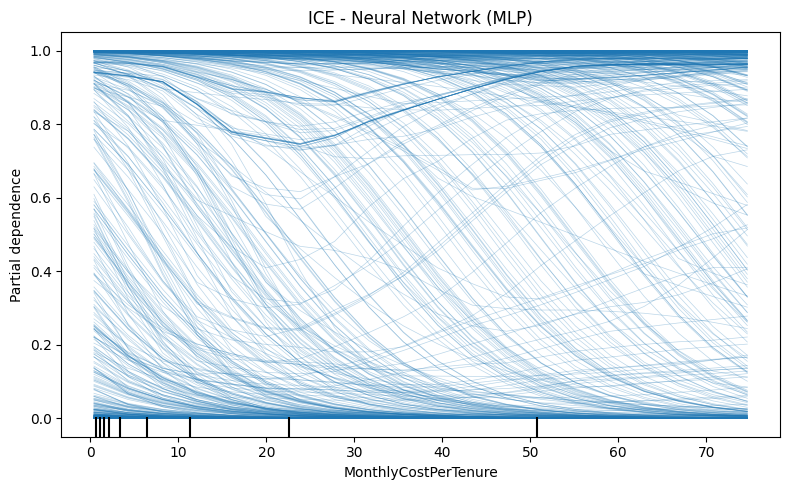

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(nn_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - Neural Network (MLP)")
plt.tight_layout()
plt.show()

This ICE plot shows how MonthlyCostPerTenure influences churn predictions for individual customers.

Many lines start high and decrease: For several customers, increasing MonthlyCostPerTenure reduces churn probability, possibly indicating that early high-cost users are seen as more committed.

Some lines remain flat: These customers' churn predictions are insensitive to changes in this feature, suggesting other features dominate for them.

Others slightly increase: A few lines trend upward, implying higher cost-per-tenure increases churn risk for those customers.

The ICE plot reveals customer-specific variability in how MonthlyCostPerTenure affects churn. The MLP model shows a nonlinear and heterogeneous response, aligning with the smoother global trend seen in the PDP.

### ALE

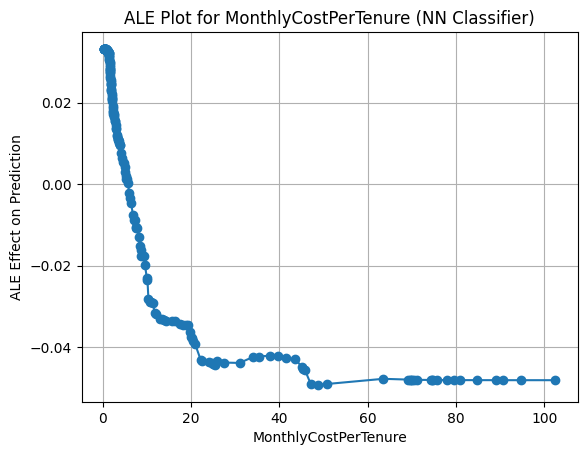

In [ ]:
predictor = lambda x: nn_final.predict_proba(x)[:, 1]

ale_explainer = ALE(predictor=predictor, feature_names=X_test_final.columns.tolist())

ale_exp = ale_explainer.explain(X_test_final.values)

feature_index = X_test_final.columns.tolist().index('MonthlyCostPerTenure')

plt.plot(ale_exp.feature_values[feature_index], ale_exp.ale_values[feature_index], marker='o')
plt.title('ALE Plot for MonthlyCostPerTenure (NN Classifier)')
plt.xlabel('MonthlyCostPerTenure')
plt.ylabel('ALE Effect on Prediction')
plt.grid(True)
plt.show()

At very low values of MonthlyCostPerTenure (near 0), the ALE effect is strongly positive, meaning the model associates low cost per tenure with higher churn probability.

As the value increases (0 to 20), the effect drops sharply, indicating that increased cost per tenure early on reduces churn likelihood.

Beyond 20, the curve flattens at a negative ALE effect (around -0.04), suggesting that higher values of MonthlyCostPerTenure consistently reduce churn prediction in the model.